In [9]:
# import some packages
from __future__ import division, print_function, unicode_literals
import numpy as np
import os
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'classification'

In [10]:
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID, fig_id + '.png')
    print('Saveing figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [11]:
def sort_by_target(mnist):
    recorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[recorder_train]
    mnist.target[:60000] = mnist.target[recorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
    

In [12]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.uint8)
    sort_by_target(mnist)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist['data'], mnist['target']

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=uint8))

In [13]:
print('mnist data shape: ', mnist.data.shape)
print('\n')

X, y = mnist['data'], mnist['target']
print('X.shape: ', X.shape)
print('y.shape: ', y.shape)

mnist data shape:  (70000, 784)


X.shape:  (70000, 784)
y.shape:  (70000,)


Saveing figure some_digit_plot


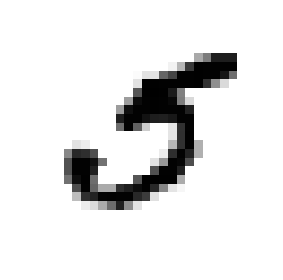

In [14]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
save_fig('some_digit_plot')
plt.show()

In [15]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis('off')


In [16]:
def plot_digits(instances, images_per_row, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis('off')

In [17]:
plt.figure(figsize=(9, 9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig('more_digits_plot')
plt.show()

Saveing figure more_digits_plot


In [18]:
# split train and test data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifier

In [20]:
# number 5 as example
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [21]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

## K-折交叉验证

### K 折交叉验证：
  随机的将数据分切为K个互不相交的大小相同的子集，然后利用K-1个子集的数据训练模型，利用余下的子集进行测试模型。将这一过程对可能的K种选择重复进行，最后选出K次评测中平均测试误差最小的模型。

In [23]:
# K-fold 验证
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.9502 ,  0.96565,  0.96495])

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502


0.96565


0.96495


In [26]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    

In [27]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.909  ,  0.90715,  0.9128 ])

## Confusion Matrix

### 混淆矩阵：
  混淆矩阵的每一行表示一个实际的类别，每一列表示预测的类别。

In [28]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]], dtype=int64)

## Precision 、Recall、F1_score

###
TP:将正类预测为正类的个数。

TN:将负类预测为负类的个数。

FP:将负类预测为正类的个数。

FN:将正类预测为负类的个数。

精确度：P = TP/ (TP + FP)

召回率：R = TP/ (TP + FN)

F1-值：2/F1 = 1/P + 1/R

In [29]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.76871350203503808

In [30]:
recall_score(y_train_5, y_train_pred)

0.80132816823464303

In [31]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.78468208092485547

In [32]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 161855.74572176])

In [33]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

In [34]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')

In [36]:
from sklearn.metrics import precision_recall_curve

precision, recalls, threshold = precision_recall_curve(y_train_5, y_scores)

Saveing figure precision_recall_vs_threshold_plot


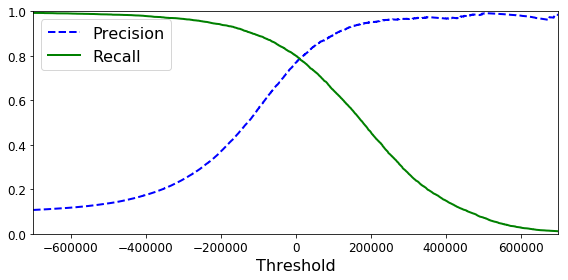

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(threshold, precision[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(threshold, recalls[:-1], 'g-', label='Recall', linewidth=2)
    plt.xlabel('Threshold', fontsize=16)
    plt.legend(loc='upper left', fontsize=16)
    plt.ylim([0, 1])
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precision, recalls, threshold)
plt.xlim([-700000, 700000])
save_fig('precision_recall_vs_threshold_plot')
plt.show()

Saveing figure precision_vs_recall_plot


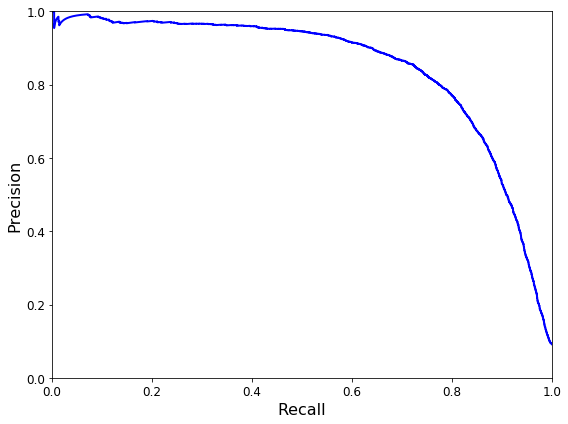

In [39]:
def plot_precision_vs_recall(precision, recalls):
    plt.plot(recalls, precision, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precision, recalls)
save_fig('precision_vs_recall_plot')
plt.show()

## ROC curves

In [40]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saveing figure roc_curve_plot


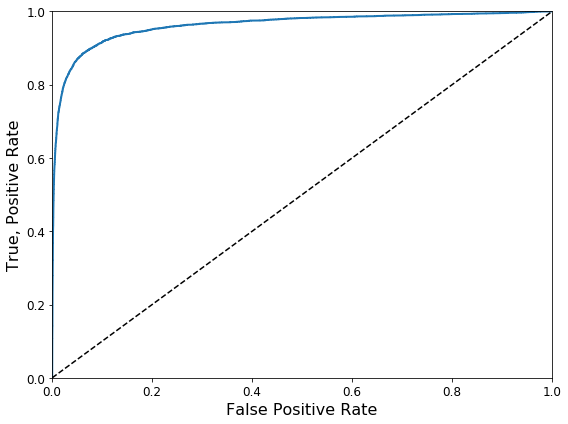

In [41]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True, Positive Rate', fontsize=16)
    
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig('roc_curve_plot')
plt.show()

In [42]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.96244965559671558

In [43]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method='predict_proba')
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Saveing figure roc_curve_comparision_plot


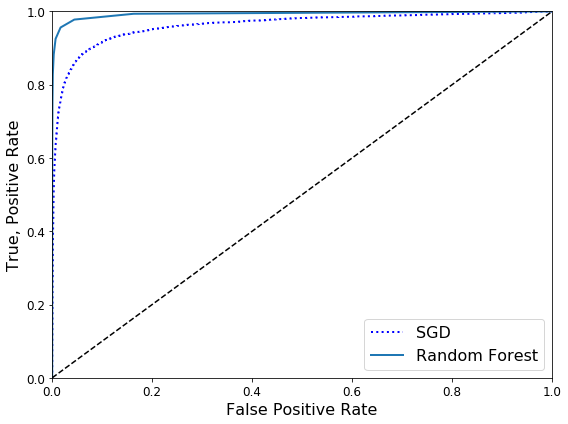

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b:', linewidth=2, label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right', fontsize=16)
save_fig('roc_curve_comparision_plot')
plt.show()

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

0.99312433660038291

In [46]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.98529734474434938

In [47]:
recall_score(y_train_5, y_train_pred_forest)

0.82826046854823832

### AUC（area under curve） 最理想的状态下为1